# Rough Models Demo (rBergomi & Rough Heston)
* Self-contained notebook using functions from `src/rough.py`
* What you’ll see:
  * Path simulation sanity checks
  * Single-strike pricing + put–call parity
  * Smile from one set of terminal states
  * ATM IV term structure
* Toggle model with a single flag: `"rough_heston"` or `"rbergomi"`


In [2]:
# 0) Imports & setup
import os, sys, math
import numpy as np
import matplotlib.pyplot as plt

# plotting style
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True
plt.rcParams["font.size"] = 12
repo_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(repo_root)
from src.rough import (
    rbergomi_paths,
    rbergomi_euro_mc,
    rough_heston_paths,
    rough_heston_euro_mc,
)
from src.black_scholes import black_scholes_price

def implied_vol_from_price_bs(S, K, T, r, price, cp="call", q=0.0, lo=1e-4, hi=4.0, tol=1e-6, iters=80):
    lo = float(lo); hi = float(hi)
    for _ in range(iters):
        mid = 0.5*(lo+hi)
        p = black_scholes_price(S, K, T, r, mid, option_type=cp, q=q)
        if p > price: hi = mid
        else: lo = mid
        if hi - lo < tol: return mid
    return mid

# helper: price from a vector of terminal prices
def mc_price_from_ST(ST, K, r, T, cp="call"):
    if cp == "call":
        payoff = np.maximum(ST - K, 0.0)
    else:
        payoff = np.maximum(K - ST, 0.0)
    DF = math.exp(-r*T)
    disc = DF * payoff
    p = float(np.mean(disc))
    se = float(np.std(disc, ddof=1) / math.sqrt(ST.size))
    return p, se


## Choose model and baseline parameters
* `model = "rough_heston"` (default) or `"rbergomi"`
* Reasonable equity-like defaults included below


In [3]:
model = "rbergomi"   # change to "rbergomi" if you want rBergomi

# common
S0    = 100.0
r     = 0.02
q     = 0.00
T     = 0.75
N     = 192
paths = 12000
seed  = 123

# roughness & correlations
H     = 0.10
rho   = -0.7

# rBergomi specifics
eta_rb  = 1.8
xi0_rb  = 0.04   # flat forward variance

# Rough Heston specifics
v0_rh   = 0.04
kappa_rh= 1.8
theta_rh= 0.04
eta_rh  = 1.8


## Simulate paths
* Runs the appropriate simulator based on `model`
* Prints shapes and ranges
* Plots a few sample paths for **S(t)** and **variance**


Shapes: (12000, 193) (12000, 193)
S range: 8.84590677473414 → 625.1137823800318
V range: 3.1560008252233637e-06 → 48.57520027046673


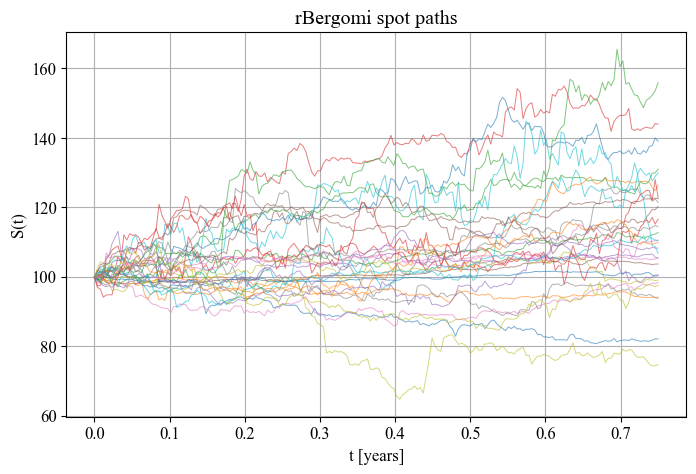

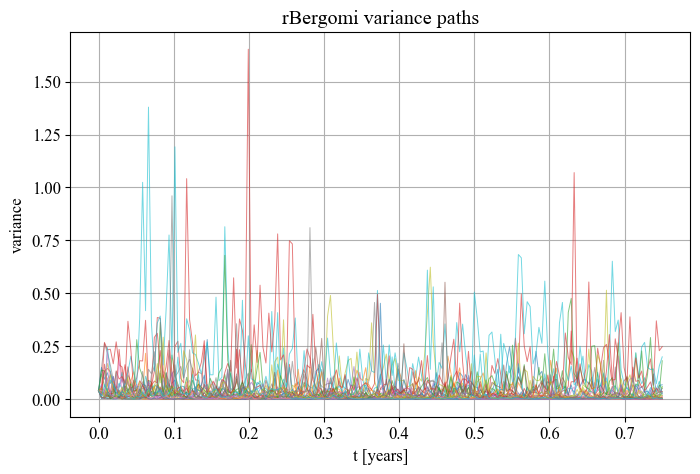

In [4]:
if model == "rbergomi":
    t, S, V = rbergomi_paths(
        S0=S0, T=T, N=N, n_paths=paths, H=H, eta=eta_rb, rho=rho,
        xi0=xi0_rb, r=r, q=q, seed=seed, fgn_method="davies-harte"
    )
    title_tag = "rBergomi"
else:
    t, S, V = rough_heston_paths(
        S0=S0, v0=v0_rh, T=T, N=N, n_paths=paths, H=H,
        kappa=kappa_rh, theta=theta_rh, eta=eta_rh, rho=rho,
        r=r, q=q, seed=seed
    )
    title_tag = "Rough Heston"

print("Shapes:", S.shape, V.shape)
print("S range:", float(S.min()), "→", float(S.max()))
print("V range:", float(V.min()), "→", float(V.max()))

# plot a subset of paths
n_show = min(30, S.shape[0])
idx = np.random.default_rng(7).choice(S.shape[0], size=n_show, replace=False)

fig, ax = plt.subplots()
ax.plot(t, S[idx].T, lw=0.7, alpha=0.6)
ax.set_title(f"{title_tag} spot paths")
ax.set_xlabel("t [years]"); ax.set_ylabel("S(t)")
plt.show()

fig, ax = plt.subplots()
ax.plot(t, V[idx].T, lw=0.7, alpha=0.6)
ax.set_title(f"{title_tag} variance paths")
ax.set_xlabel("t [years]"); ax.set_ylabel("variance")
plt.show()



## Single-strike pricing & put–call parity
* Price call/put for `K=100`
* Report ±1.96·SE intervals
* Check `C − P = S0 e^{-qT} − K e^{-rT}`


In [5]:
K = 100.0

if model == "rbergomi":
    c, se_c = rbergomi_euro_mc(S0=S0, K=K, T=T, r=r, q=q, H=H, eta=eta_rb, rho=rho, xi0=xi0_rb,
                               n_paths=paths, N=N, option="call", seed=seed)
    p, se_p = rbergomi_euro_mc(S0=S0, K=K, T=T, r=r, q=q, H=H, eta=eta_rb, rho=rho, xi0=xi0_rb,
                               n_paths=paths, N=N, option="put",  seed=seed)
else:
    c, se_c = rough_heston_euro_mc(S0=S0, v0=v0_rh, K=K, T=T, N=N, n_paths=paths, H=H,
                                   kappa=kappa_rh, theta=theta_rh, eta=eta_rh, rho=rho,
                                   r=r, q=q, option="call", seed=seed)
    p, se_p = rough_heston_euro_mc(S0=S0, v0=v0_rh, K=K, T=T, N=N, n_paths=paths, H=H,
                                   kappa=kappa_rh, theta=theta_rh, eta=eta_rh, rho=rho,
                                   r=r, q=q, option="put", seed=seed)

rhs = S0*math.exp(-q*T) - K*math.exp(-r*T)
print(f"{title_tag} Call(K=100) ≈ {c:.4f}  ± {1.96*se_c:.4f}")
print(f"{title_tag} Put (K=100) ≈ {p:.4f}  ± {1.96*se_p:.4f}")
print(f"Parity check: C − P = {c - p:.4f}   RHS = {rhs:.4f}")


rBergomi Call(K=100) ≈ 6.6756  ± 0.2458
rBergomi Put (K=100) ≈ 5.1836  ± 0.1623
Parity check: C − P = 1.4920   RHS = 1.4888


## Smile from a single simulation
* Reuse terminal prices `ST = S[:, -1]` (no re-simulation)
* Build call prices across a strike grid with error bars


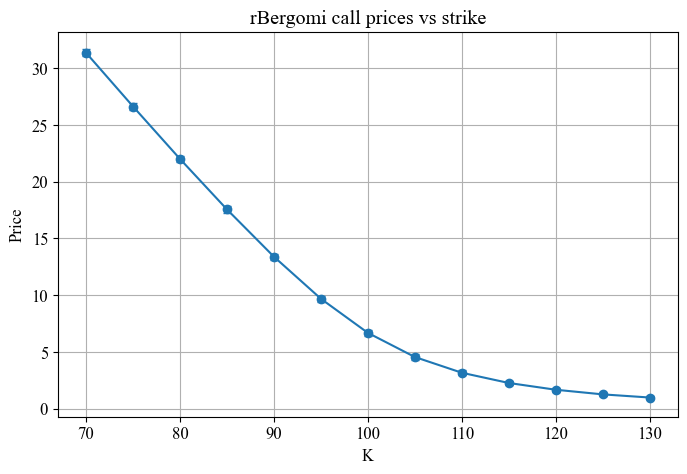

In [6]:
# 4) Smile from one ST sample
ST = S[:, -1]
strikes = np.linspace(70, 130, 13)

px, se = [], []
for k in strikes:
    p_k, se_k = mc_price_from_ST(ST, float(k), r, T, "call")
    px.append(p_k); se.append(se_k)
px = np.array(px); se = np.array(se)

fig, ax = plt.subplots()
ax.errorbar(strikes, px, yerr=1.96*se, fmt="o-", capsize=3)
ax.set_title(f"{title_tag} call prices vs strike")
ax.set_xlabel("K"); ax.set_ylabel("Price")
plt.show()


## ATM IV term structure (quick)
* For several maturities, resimulate once and compute ATM IV (BS inversion)
* Uses `K = S0` as ATM proxy


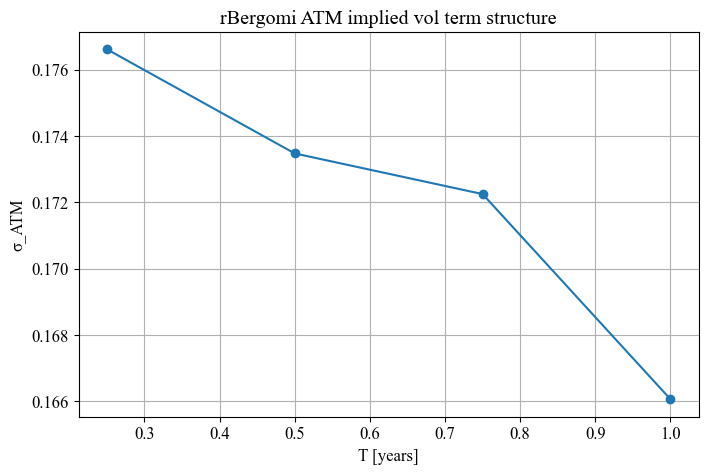

In [7]:
Ts = np.array([0.25, 0.5, 0.75, 1.0])
atm_iv = []

for TT in Ts:
    NN = max(128, int(256*TT))
    if model == "rbergomi":
        tT, ST_paths, VT_paths = rbergomi_paths(S0=S0, T=TT, N=NN, n_paths=paths, H=H,
                                                eta=eta_rb, rho=rho, xi0=xi0_rb,
                                                r=r, q=q, seed=seed, fgn_method="davies-harte")
    else:
        tT, ST_paths, VT_paths = rough_heston_paths(S0=S0, v0=v0_rh, T=TT, N=NN, n_paths=paths, H=H,
                                                    kappa=kappa_rh, theta=theta_rh, eta=eta_rh, rho=rho,
                                                    r=r, q=q, seed=seed)
    STT = ST_paths[:, -1]
    c_atm, _ = mc_price_from_ST(STT, S0, r, TT, "call")
    iv = implied_vol_from_price_bs(S0, S0, TT, r, c_atm, "call", q=q)
    atm_iv.append(iv)

fig, ax = plt.subplots()
ax.plot(Ts, atm_iv, marker="o")
ax.set_title(f"{title_tag} ATM implied vol term structure")
ax.set_xlabel("T [years]"); ax.set_ylabel("σ_ATM")
plt.show()


## Sensitivity: effect of roughness H on price (optional)
* Keep parameters fixed, vary `H` across a small set
* Shows how the call price moves with roughness (MC ±1.96·SE)


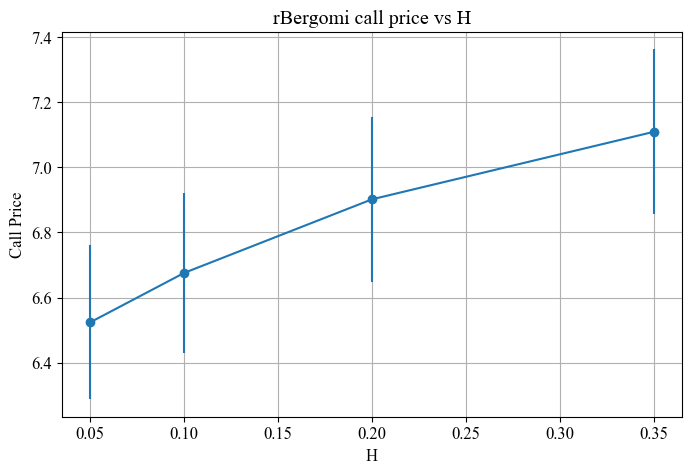

In [8]:
# 6) Price vs H (optional)
Hs = [0.05, 0.10, 0.20, 0.35]
prices_H, err_H = [], []

for Hh in Hs:
    if model == "rbergomi":
        pH, seH = rbergomi_euro_mc(S0=S0, K=K, T=T, r=r, q=q, H=Hh, eta=eta_rb, rho=rho, xi0=xi0_rb,
                                   n_paths=paths, N=N, option="call", seed=seed)
    else:
        pH, seH = rough_heston_euro_mc(S0=S0, v0=v0_rh, K=K, T=T, N=N, n_paths=paths, H=Hh,
                                       kappa=kappa_rh, theta=theta_rh, eta=eta_rh, rho=rho,
                                       r=r, q=q, option="call", seed=seed)
    prices_H.append(pH); err_H.append(seH)

fig, ax = plt.subplots()
ax.errorbar(Hs, prices_H, yerr=1.96*np.array(err_H), fmt="o-")
ax.set_title(f"{title_tag} call price vs H")
ax.set_xlabel("H"); ax.set_ylabel("Call Price")
plt.show()


## Implied Volatility Surfaces (rBergomi & Rough Heston)
* We’ll build IV surfaces over a grid of maturities × strikes.
* For each maturity:
  * simulate paths **once**,
  * reuse terminal prices `ST` to price all strikes,
  * invert Black–Scholes to get IVs.
* Outputs:
  * price surface, IV surface, standard-error surface,
  * 3D surface and 2D heatmap for quick inspection.


In [9]:
# helpers: BS IV, price bounds, grids, and plotting

import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (needed to enable 3D)

# already imported from earlier cell:
#   from black_scholes import black_scholes_price
#   from rough import rbergomi_paths, rough_heston_paths

def bs_implied_vol(price, S, K, T, r, cp="call", q=0.0, lo=1e-4, hi=4.0, tol=1e-6, iters=80):
    """Bracketed search; robust for our demo."""
    # no-arbitrage bounds clamp (keeps inversion well-posed)
    if cp == "call":
        lb = max(0.0, S*math.exp(-q*T) - K*math.exp(-r*T))
        ub = S*math.exp(-q*T)
    else:
        lb = max(0.0, K*math.exp(-r*T) - S*math.exp(-q*T))
        ub = K*math.exp(-r*T)
    p = float(np.clip(price, lb, ub))
    a, b = float(lo), float(hi)
    for _ in range(iters):
        m = 0.5*(a+b)
        pm = black_scholes_price(S, K, T, r, m, option_type=cp, q=q)
        if pm > p: b = m
        else: a = m
        if b - a < tol: return m
    return m

def mc_price_from_ST(ST, K, r, T, cp="call"):
    if cp == "call": pay = np.maximum(ST - K, 0.0)
    else:            pay = np.maximum(K - ST, 0.0)
    DF = math.exp(-r*T)
    disc = DF * pay
    price = float(np.mean(disc))
    se    = float(np.std(disc, ddof=1) / math.sqrt(ST.size))
    return price, se

def plot_surface_3d(Ks, Ts, Z, title, zlabel):
    Kg, Tg = np.meshgrid(Ks, Ts)
    fig = plt.figure(figsize=(9,6))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(Kg, Tg, Z, linewidth=0, antialiased=True)
    ax.set_xlabel("K"); ax.set_ylabel("T [years]"); ax.set_zlabel(zlabel)
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

def plot_heatmap(Ks, Ts, Z, title, zlabel):
    fig, ax = plt.subplots(figsize=(8,5))
    im = ax.pcolormesh(Ks, Ts, Z, shading="auto")
    ax.set_xlabel("K"); ax.set_ylabel("T [years]"); ax.set_title(title)
    cbar = fig.colorbar(im, ax=ax); cbar.set_label(zlabel)
    plt.tight_layout()
    plt.show()


## Configure the surface grids
* Keep it modest for runtime; bump `paths_surface` if you want smoother IVs.


In [10]:
# grids
Ks = np.linspace(70, 130, 13)        # 13 strikes
Ts = np.array([0.25, 0.5, 0.75, 1.0])# 4 maturities

# Monte Carlo settings for the surface (can be lighter than earlier demo)
paths_surface = 8000
steps_per_year = 256
seed_surface = 2024


## Build surfaces — generic routine for *both* models
* Chooses simulator by `model` name (`"rbergomi"` or `"rough_heston"`).
* Returns price, IV, and stderr arrays shaped `(len(Ts), len(Ks))`.


In [11]:
def build_surfaces(model, S0, r, q, H, rho,
                   Ks, Ts, paths_surface, steps_per_year, seed_surface,
                   # rBergomi params:
                   eta_rb=None, xi0_rb=None,
                   # Rough Heston params:
                   v0_rh=None, kappa_rh=None, theta_rh=None, eta_rh=None):
    nT, nK = len(Ts), len(Ks)
    price = np.zeros((nT, nK))
    iv    = np.zeros((nT, nK))
    se    = np.zeros((nT, nK))

    for i, T in enumerate(Ts):
        N = max(128, int(steps_per_year * T))  # keep dt ~ 1/256 yr
        if model == "rbergomi":
            t, S_paths, V_paths = rbergomi_paths(
                S0=S0, T=T, N=N, n_paths=paths_surface,
                H=H, eta=eta_rb, rho=rho, xi0=xi0_rb, r=r, q=q, seed=seed_surface+i, fgn_method="davies-harte"
            )
        elif model == "rough_heston":
            t, S_paths, V_paths = rough_heston_paths(
                S0=S0, v0=v0_rh, T=T, N=N, n_paths=paths_surface,
                H=H, kappa=kappa_rh, theta=theta_rh, eta=eta_rh, rho=rho,
                r=r, q=q, seed=seed_surface+i
            )
        else:
            raise ValueError("model must be 'rbergomi' or 'rough_heston'")

        ST = S_paths[:, -1]
        for j, K in enumerate(Ks):
            p, s = mc_price_from_ST(ST, float(K), r, T, "call")
            price[i, j] = p
            se[i, j]    = s
            iv[i, j]    = bs_implied_vol(p, S0, float(K), T, r, cp="call", q=q)
    return price, iv, se


## rBergomi IV surface
* Uses your rBergomi defaults (`H`, `eta_rb`, `rho`, `xi0_rb`).


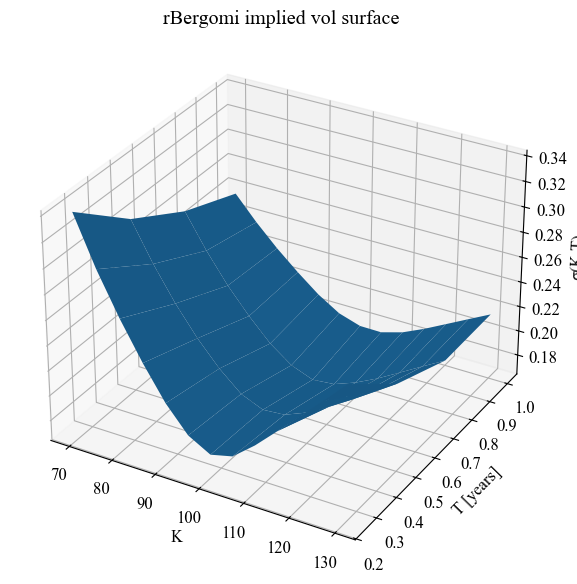

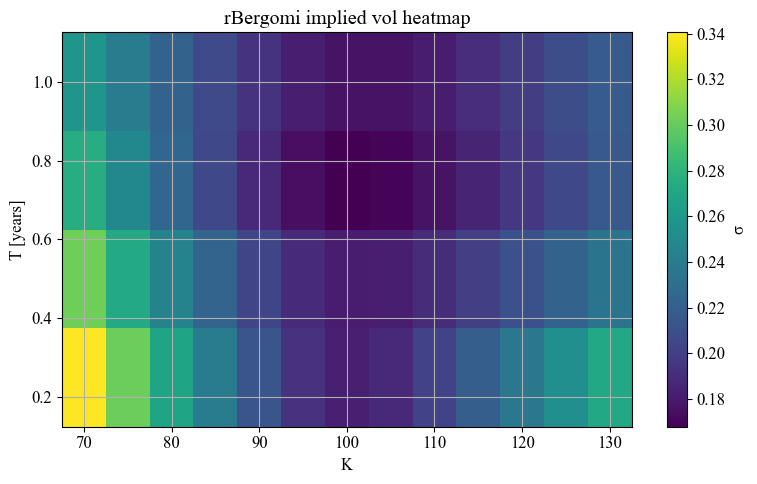

In [12]:
price_rb, iv_rb, se_rb = build_surfaces(
    model="rbergomi",
    S0=S0, r=r, q=q, H=H, rho=rho,
    Ks=Ks, Ts=Ts, paths_surface=paths_surface, steps_per_year=steps_per_year, seed_surface=seed_surface,
    eta_rb=eta_rb, xi0_rb=xi0_rb
)

# plots
plot_surface_3d(Ks, Ts, iv_rb, "rBergomi implied vol surface", "σ(K,T)")
plot_heatmap(Ks, Ts, iv_rb, "rBergomi implied vol heatmap", "σ")


## Rough Heston IV surface
* Uses your Rough Heston defaults (`v0_rh`, `kappa_rh`, `theta_rh`, `eta_rh`, `H`, `rho`).


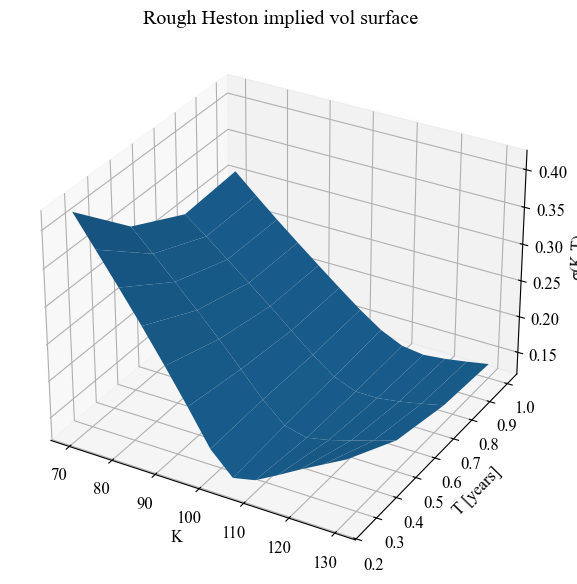

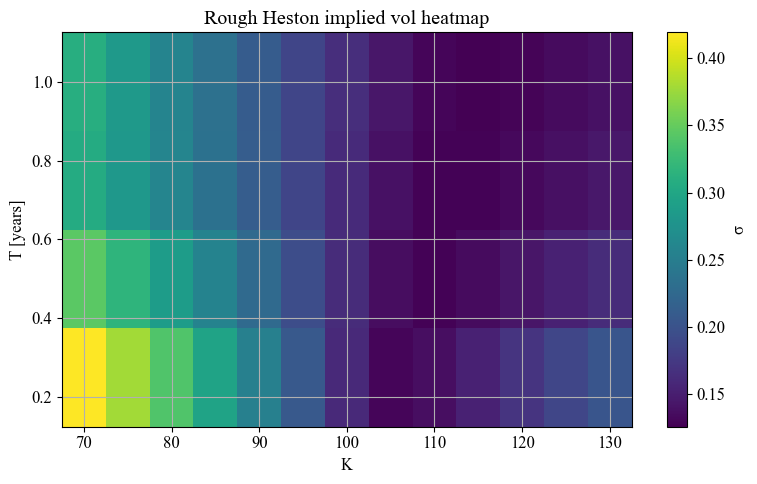

In [13]:
price_rh, iv_rh, se_rh = build_surfaces(
    model="rough_heston",
    S0=S0, r=r, q=q, H=H, rho=rho,
    Ks=Ks, Ts=Ts, paths_surface=paths_surface, steps_per_year=steps_per_year, seed_surface=seed_surface,
    v0_rh=v0_rh, kappa_rh=kappa_rh, theta_rh=theta_rh, eta_rh=eta_rh
)

# plots
plot_surface_3d(Ks, Ts, iv_rh, "Rough Heston implied vol surface", "σ(K,T)")
plot_heatmap(Ks, Ts, iv_rh, "Rough Heston implied vol heatmap", "σ")


## Compare ATM term structures (RB vs RH)
* Extract the **ATM** column (`K ≈ S0`) from each surface for a quick side-by-side.


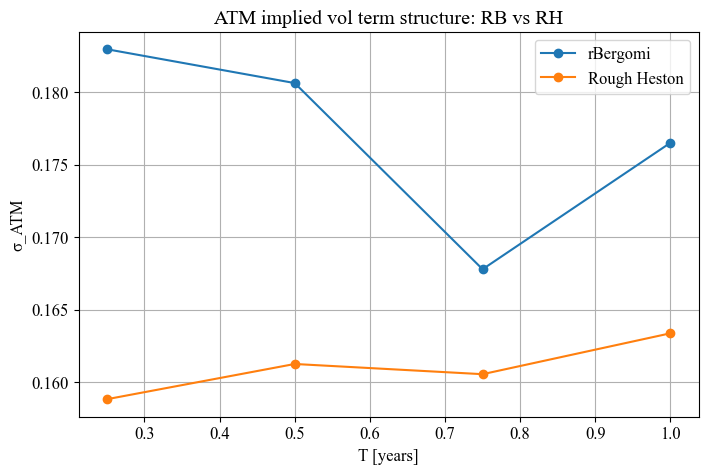

In [14]:
# pick the strike nearest to S0 as ATM
j_atm = int(np.argmin(np.abs(Ks - S0)))

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(Ts, iv_rb[:, j_atm], marker="o", label="rBergomi")
ax.plot(Ts, iv_rh[:, j_atm], marker="o", label="Rough Heston")
ax.set_title("ATM implied vol term structure: RB vs RH")
ax.set_xlabel("T [years]"); ax.set_ylabel("σ_ATM")
ax.legend()
plt.show()


## Notes & knobs
* Monte Carlo **variance** dominates IV noise; to smooth surfaces:
  * increase `paths_surface` (SE ↓ ~ 1/√N),
  * bump `steps_per_year` (reduces time-discretization bias),
  * reuse common RNG seeds across maturities for cleaner comparisons.
* Deep ITM/OTM strikes can be numerically stiff for IV inversion; we clamp prices to **no-arbitrage bounds** before inversion.
* rBergomi here uses **Hosking** fGn (O(N²) per path); for heavy grids, switch to an FFT fGn (Davies–Harte) in your `src/rough.py` implementation to speed up.


# Side-by-Side IV Surfaces (Heston vs rBergomi) with Shared Colormap
* Same strike–maturity grid for both models
* Single colormap and shared color bar for visual comparability
* Bonus: surfaces in normalized log-moneyness η = ln(K/F)/√T vs time τ


In [15]:
# --- config (feel free to tweak) ---
Ks = np.linspace(80, 120, 17)             # strikes
Ts = np.linspace(0.25, 2.00, 15)          # maturities (years)
paths_surface = 7000                       # MC paths for rBergomi
steps_per_year = 256                       # time steps per year for rBergomi
seed_surface = 4242

# model params (use your existing ones from the demo cells)
# S0, r, q, H, rho, eta_rb, xi0_rb already defined in your notebook

# --- helpers ---
def bs_iv_from_price(S, K, T, r, price, cp="call", q=0.0, lo=1e-4, hi=4.0, tol=1e-6, iters=80):
    # clamp to no-arb bounds for stability
    if cp == "call":
        lb = max(0.0, S*np.exp(-q*T) - K*np.exp(-r*T))
        ub = S*np.exp(-q*T)
    else:
        lb = max(0.0, K*np.exp(-r*T) - S*np.exp(-q*T))
        ub = K*np.exp(-r*T)
    p = float(np.clip(price, lb, ub))
    a, b = float(lo), float(hi)
    for _ in range(iters):
        m = 0.5*(a+b)
        pm = black_scholes_price(S, K, T, r, m, option_type=cp, q=q)
        if pm > p: b = m
        else: a = m
        if b - a < tol: return m
    return m

def mc_price_from_ST(ST, K, r, T):
    DF = math.exp(-r*T)
    return float(DF * np.maximum(ST-K, 0.0).mean())

from src.heston import heston_price

# --- build IV surface for classic Heston via COS price then BS inversion ---
iv_heston = np.zeros((len(Ts), len(Ks)))
for i, T_ in enumerate(Ts):
    for j, K_ in enumerate(Ks):
        price_H = heston_price(
            S0=S0, K=K_, T=T_, r=r,
            kappa=kappa_rh, theta=theta_rh, sigma=eta_rh, v0=v0_rh, rho=rho,
            option="call", N=4096, L=12
        )
        iv_heston[i, j] = bs_iv_from_price(S0, K_, T_, r, price_H, "call", q=q)

# --- build IV surface for rBergomi (one sim per maturity, reuse ST for all K) ---
iv_rb = np.zeros_like(iv_heston)
for i, T_ in enumerate(Ts):
    N_T = max(128, int(steps_per_year * T_))
    t, S_paths, V_paths = rbergomi_paths(
        S0=S0, T=T_, N=N_T, n_paths=paths_surface,
        H=H, eta=eta_rb, rho=rho, xi0=xi0_rb, r=r, q=q, seed=seed_surface+i, fgn_method="davies-harte"
    )
    ST = S_paths[:, -1]
    for j, K_ in enumerate(Ks):
        p = mc_price_from_ST(ST, K_, r, T_)
        iv_rb[i, j] = bs_iv_from_price(S0, K_, T_, r, p, "call", q=q)

# --- choose shared colormap limits across both surfaces ---
vmin = float(min(iv_heston.min(), iv_rb.min()))
vmax = float(max(iv_heston.max(), iv_rb.max()))



# --- build IV surface for Rough Heston (one sim per maturity) ---
iv_rh = np.zeros((len(Ts), len(Ks)))

for i, T_ in enumerate(Ts):
    N_T = max(128, int(steps_per_year * T_))  # keep dt ~ 1/256 yr
    tR, S_pathsR, V_pathsR = rough_heston_paths(
        S0=S0, v0=v0_rh, T=T_, N=N_T, n_paths=paths_surface,
        H=H, kappa=kappa_rh, theta=theta_rh, eta=eta_rh, rho=rho,
        r=r, q=q, seed=seed_surface + 10 + i  # offset seed to avoid correlation with RB
    )
    ST = S_pathsR[:, -1]
    for j, K_ in enumerate(Ks):
        # MC call price from the same ST sample for every strike
        p = mc_price_from_ST(ST, K_, r, T_)
        iv_rh[i, j] = bs_iv_from_price(S0, K_, T_, r, p, "call", q=q)

# --- update shared colormap limits to include all three surfaces ---
vmin = float(min(iv_heston.min(), iv_rb.min(), iv_rh.min()))
vmax = float(max(iv_heston.max(), iv_rb.max(), iv_rh.max()))
# or pin to a fixed band, e.g. 0–30%:
vmin, vmax = 0.00, 0.30



## Plot 1: Strike–Maturity surfaces (shared colormap + single colorbar)


C:\Users\datog\AppData\Local\Temp\ipykernel_16740\3071808603.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis")
C:\Users\datog\AppData\Local\Temp\ipykernel_16740\3071808603.py:97: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.90, 0.95])


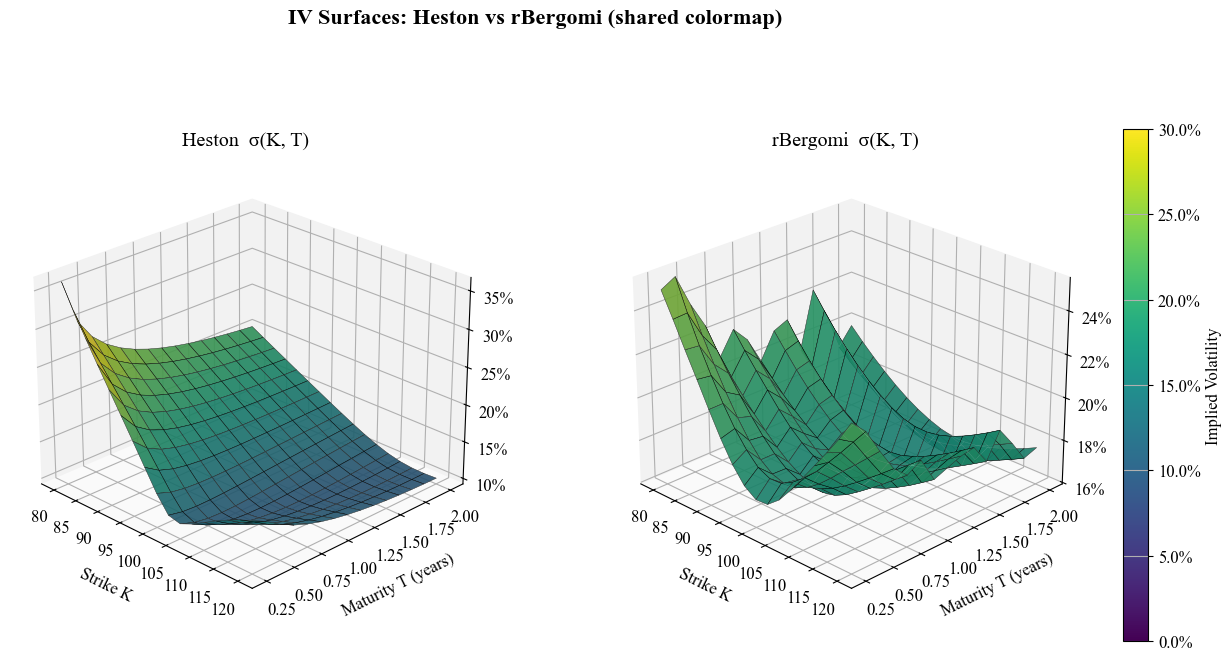

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from matplotlib.ticker import FuncFormatter
from matplotlib import rcParams
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# ----------------------------
# Assumes S0, r, q, Ks, Ts, iv_heston, iv_rb are already defined
# ----------------------------
q = 0.0 if 'q' not in globals() else q
Kg, Tg = np.meshgrid(Ks, Ts)
F_grid = S0 * np.exp((r - q) * Tg)
m_grid = np.log(Kg / F_grid) / np.sqrt(Tg)

# ----------------------------
# Styling
# ----------------------------
rcParams['font.family'] = 'Times New Roman'
fmt_pct = FuncFormatter(lambda x, pos: f"{100*x:.0f}%")

# Set one common color range for both surfaces (override with manual bounds if desired)
vmin = float(np.nanmin([iv_heston.min(), iv_rb.min()]))
vmax = float(np.nanmax([iv_heston.max(), iv_rb.max()]))
# Or force explicit limits like 0 to 30%
vmin, vmax = 0.00, 0.30

norm = colors.Normalize(vmin=vmin, vmax=vmax)
cmap = cm.get_cmap("viridis")

# ----------------------------
# Figure and axes
# ----------------------------
fig = plt.figure(figsize=(14, 8))

# Make more space between subplots and leave room on the right for the colorbar
gs = fig.add_gridspec(
    1, 2,
    wspace=0.30             # increase this for more gap between the two plots
)
ax1 = fig.add_subplot(gs[0, 0], projection="3d")
ax2 = fig.add_subplot(gs[0, 1], projection="3d")
elev, azim = 25, -45

# ----------------------------
# Left: Heston (K, T)
# ----------------------------
surf1 = ax1.plot_surface(
    Kg, Tg, iv_heston,
    facecolors=cmap(norm(iv_heston)),
    rstride=1, cstride=1,
    linewidth=0.3, edgecolor="black",
    antialiased=True, alpha=0.9
)
ax1.plot_wireframe(
    Kg, Tg, iv_heston,
    rstride=2, cstride=2,
    color=(1, 1, 1, 0.18), linewidth=0.35
)
ax1.view_init(elev=elev, azim=azim)
ax1.set_title("Heston  σ(K, T)")
ax1.set_xlabel("Strike K", labelpad=8)
ax1.set_ylabel("Maturity T (years)", labelpad=8)
# ax1.set_zlabel("Implied Volatility", labelpad=10)
ax1.zaxis.set_major_formatter(fmt_pct)

# ----------------------------
# Right: rBergomi (K, T)  [swap Kg->m_grid here if you prefer moneyness]
# ----------------------------
surf2 = ax2.plot_surface(
    Kg, Tg, iv_rb,
    facecolors=cmap(norm(iv_rb)),
    rstride=1, cstride=1,
    linewidth=0.3, edgecolor="black",
    antialiased=True, alpha=0.9
)
ax2.plot_wireframe(
    Kg, Tg, iv_rb,
    rstride=2, cstride=2,
    color=(1, 1, 1, 0.18), linewidth=0.35
)
ax2.view_init(elev=elev, azim=azim)
ax2.set_title("rBergomi  σ(K, T)")
ax2.set_xlabel("Strike K", labelpad=8)
ax2.set_ylabel("Maturity T (years)", labelpad=8)
# ax2.set_zlabel("Implied Volatility", labelpad=10)
ax2.zaxis.set_major_formatter(fmt_pct)

# ----------------------------
# Shared colorbar on the far right
# ----------------------------
# Use ScalarMappable with same norm and cmap to share colors
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
mappable.set_array([])

# Reserve space on the right for colorbar
plt.tight_layout(rect=[0, 0, 0.90, 0.95])

# Place a dedicated colorbar axis to the far right
cbar_ax = fig.add_axes([0.92, 0.18, 0.018, 0.64])
cbar = fig.colorbar(mappable, cax=cbar_ax)
cbar.set_label("Implied Volatility")
cbar.formatter = FuncFormatter(lambda x, pos: f"{100*x:.1f}%")
cbar.update_ticks()

# Slight nudge of the right subplot to the left to balance spacing
pos2 = ax2.get_position()
ax2.set_position([pos2.x0 - 0.01, pos2.y0, pos2.width, pos2.height])

# ----------------------------
# Grid, panes, and title
# ----------------------------
for ax in (ax1, ax2):
    ax.grid(True, linestyle="--", linewidth=0.4, alpha=0.7)
    ax.xaxis.set_pane_color((0.95, 0.95, 0.95, 1.0))
    ax.yaxis.set_pane_color((0.95, 0.95, 0.95, 1.0))
    ax.zaxis.set_pane_color((0.98, 0.98, 0.98, 1.0))

fig.suptitle("IV Surfaces: Heston vs rBergomi (shared colormap)", fontsize=16, fontweight="bold", y=0.97)

# Optional: save
# plt.savefig(".../iv_surfaces_heston_vs_rbergomi.png", dpi=150, bbox_inches="tight", facecolor="white")

plt.show()


## Plot 2: Normalized log-moneyness η = ln(K/F)/√T vs τ = T (shared colormap)
* Forward $ F(T) = S_0 e^{(r-q)T} $
* Same colormap & colorbar across both models for apples-to-apples comparison


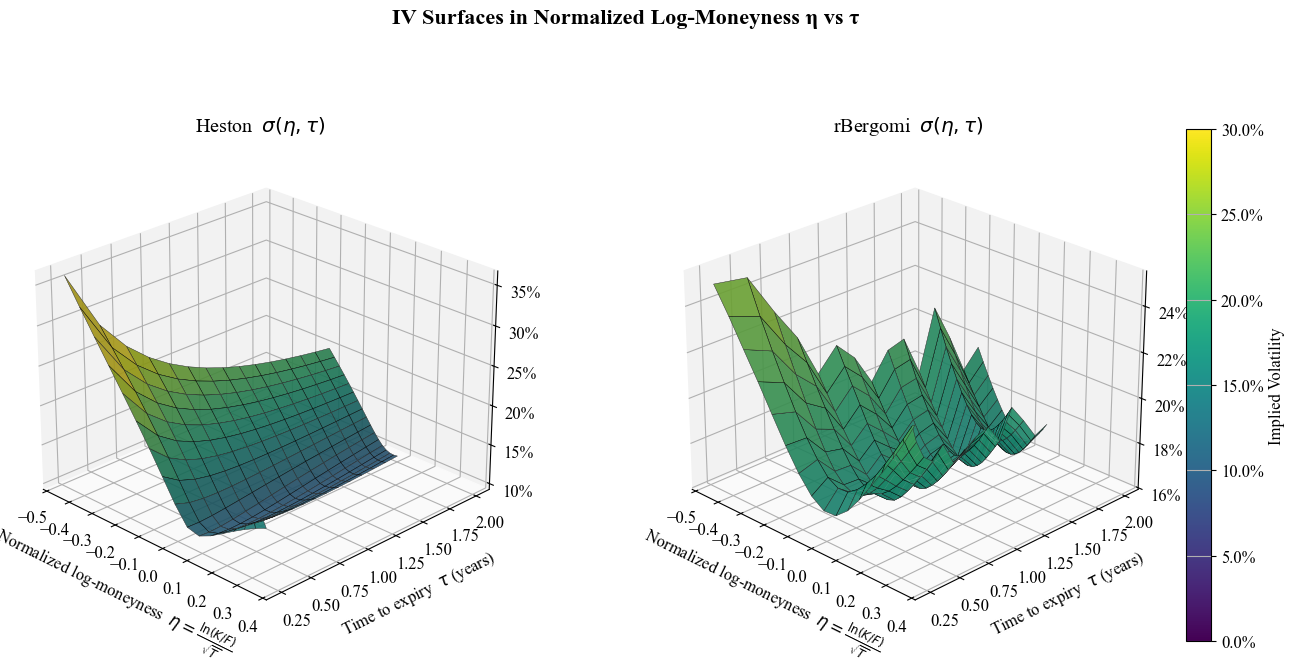

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, colors, rcParams
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# ----------------------------
# Assumes S0, r, q, Ks, Ts, iv_heston, iv_rb, and cmap/norm exist
# If not, set cmap/norm explicitly; example fixed range 0–30%:
# vmin, vmax = 0.00, 0.30
# norm = colors.Normalize(vmin=vmin, vmax=vmax)
# cmap = cm.get_cmap("viridis")
# ----------------------------
q = 0.0 if 'q' not in globals() else q
rcParams['font.family'] = 'Times New Roman'
fmt_pct = FuncFormatter(lambda x, pos: f"{100*x:.0f}%")

# Grids
Kg, Tg = np.meshgrid(Ks, Ts)
# Safe η: avoid divide by zero if Ts contains 0
T_safe = np.where(Tg <= 0.0, np.finfo(float).eps, Tg)
F = S0 * np.exp((r - q) * Ts)               # shape (len(Ts),)
eta_grid = np.log(Kg / F[:, None]) / np.sqrt(T_safe)



# Or force explicit limits like 0 to 30%
vmin, vmax = 0.00, 0.30

# ----------------------------
# Figure layout with extra spacing and reserved colorbar margin
# ----------------------------
fig = plt.figure(figsize=(14, 8))
gs = fig.add_gridspec(1, 2, left=0.06, right=0.88, wspace=0.3)
ax1 = fig.add_subplot(gs[0, 0], projection="3d")
ax2 = fig.add_subplot(gs[0, 1], projection="3d") 

elev, azim = 25, -45

# ----------------------------
# Left: Heston σ(η, τ)
# ----------------------------
surf1 = ax1.plot_surface(
    eta_grid, Tg, iv_heston,
    facecolors=cmap(norm(iv_heston)),
    rstride=1, cstride=1,
    linewidth=0.3, edgecolor="black",
    antialiased=True, alpha=0.9
)
ax1.plot_wireframe(
    eta_grid, Tg, iv_heston,
    rstride=2, cstride=2,
    color=(1, 1, 1, 0.18), linewidth=0.35
)
ax1.view_init(elev=elev, azim=azim)
ax1.set_title(r"Heston  $\sigma(\eta, \tau)$")
ax1.set_xlabel(r"Normalized log-moneyness  $\eta=\frac{\ln(K/F)}{\sqrt{T}}$", labelpad=8)
ax1.set_ylabel(r"Time to expiry  $\tau$ (years)", labelpad=8)
ax1.zaxis.set_major_formatter(fmt_pct)

# ----------------------------
# Right: rBergomi σ(η, τ)
# ----------------------------
surf2 = ax2.plot_surface(
    eta_grid, Tg, iv_rb,
    facecolors=cmap(norm(iv_rb)),
    rstride=1, cstride=1,
    linewidth=0.3, edgecolor="black",
    antialiased=True, alpha=0.9
)
ax2.plot_wireframe(
    eta_grid, Tg, iv_rb,
    rstride=2, cstride=2,
    color=(1, 1, 1, 0.18), linewidth=0.35
)
ax2.view_init(elev=elev, azim=azim)
ax2.set_title(r"rBergomi  $\sigma(\eta, \tau)$")
ax2.set_xlabel(r"Normalized log-moneyness  $\eta=\frac{\ln(K/F)}{\sqrt{T}}$", labelpad=8)
ax2.set_ylabel(r"Time to expiry  $\tau$ (years)", labelpad=8)
ax2.zaxis.set_major_formatter(fmt_pct)

# ----------------------------
# Shared colorbar on the far right
# ----------------------------
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
mappable.set_array([])
cbar_ax = fig.add_axes([0.90, 0.18, 0.018, 0.64])
cbar = fig.colorbar(mappable, cax=cbar_ax)
cbar.set_label("Implied Volatility")
cbar.formatter = FuncFormatter(lambda x, pos: f"{100*x:.1f}%")
cbar.update_ticks()

# ----------------------------
# Aesthetics: grids, panes, title
# ----------------------------
for ax in (ax1, ax2):
    ax.grid(True, linestyle="--", linewidth=0.4, alpha=0.7)
    ax.xaxis.set_pane_color((0.95, 0.95, 0.95, 1.0))
    ax.yaxis.set_pane_color((0.95, 0.95, 0.95, 1.0))
    ax.zaxis.set_pane_color((0.98, 0.98, 0.98, 1.0))

fig.suptitle("IV Surfaces in Normalized Log-Moneyness η vs τ", fontsize=16, fontweight="bold", y=0.97)
plt.show()


C:\Users\datog\AppData\Local\Temp\ipykernel_16740\2585370902.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis")
C:\Users\datog\AppData\Local\Temp\ipykernel_16740\2585370902.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 0.95])


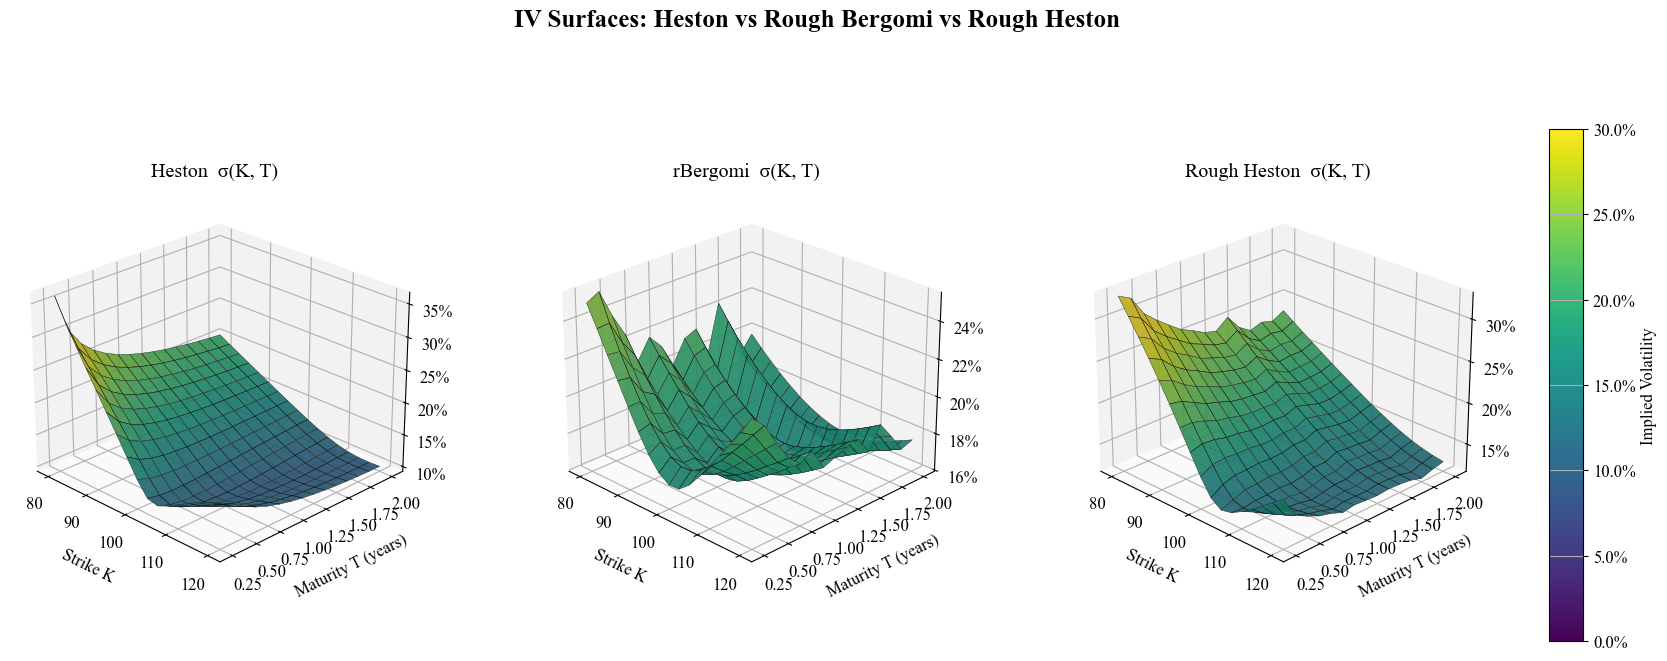

In [22]:
from matplotlib import cm, colors
from matplotlib.ticker import FuncFormatter
from matplotlib import rcParams

rcParams['font.family'] = 'Times New Roman'
fmt_pct = FuncFormatter(lambda x, pos: f"{100*x:.0f}%")

Kg, Tg = np.meshgrid(Ks, Ts)
norm = colors.Normalize(vmin=vmin, vmax=vmax)
cmap = cm.get_cmap("viridis")

fig = plt.figure(figsize=(19, 8))
gs = fig.add_gridspec(1, 3, wspace=0.30)
ax1 = fig.add_subplot(gs[0, 0], projection="3d")
ax2 = fig.add_subplot(gs[0, 1], projection="3d")
ax3 = fig.add_subplot(gs[0, 2], projection="3d")
elev, azim = 25, -45

def draw(ax, Z, title):
    ax.plot_surface(Kg, Tg, Z, facecolors=cmap(norm(Z)),
                    rstride=1, cstride=1, linewidth=0.3, edgecolor="black",
                    antialiased=True, alpha=0.9)
    ax.plot_wireframe(Kg, Tg, Z, rstride=2, cstride=2,
                      color=(1,1,1,0.18), linewidth=0.35)
    ax.view_init(elev=elev, azim=azim)
    ax.set_title(title); ax.set_xlabel("Strike K", labelpad=8)
    ax.set_ylabel("Maturity T (years)", labelpad=8)
    ax.zaxis.set_major_formatter(fmt_pct)
    ax.grid(True, linestyle="--", linewidth=0.4, alpha=0.7)
    ax.xaxis.set_pane_color((0.95,0.95,0.95,1.0))
    ax.yaxis.set_pane_color((0.95,0.95,0.95,1.0))
    ax.zaxis.set_pane_color((0.98,0.98,0.98,1.0))

draw(ax1, iv_heston, "Heston  σ(K, T)")
draw(ax2, iv_rb,     "rBergomi  σ(K, T)")
draw(ax3, iv_rh,     "Rough Heston  σ(K, T)")

mappable = cm.ScalarMappable(norm=norm, cmap=cmap); mappable.set_array([])
plt.tight_layout(rect=[0, 0, 0.92, 0.95])
cbar_ax = fig.add_axes([0.935, 0.18, 0.018, 0.64])
cbar = fig.colorbar(mappable, cax=cbar_ax)
cbar.set_label("Implied Volatility")
cbar.formatter = FuncFormatter(lambda x, pos: f"{100*x:.1f}%")
cbar.update_ticks()

fig.suptitle("IV Surfaces: Heston vs Rough Bergomi vs Rough Heston",
             fontsize=18, fontweight="bold", y=0.97,x=0.55)
plt.show()
